LTOD calculations

Take 3 days worth of gsx input swath data for a sensor
    for each swath locate all measurements that lie between 70 and 71 N (or S) latitude
    save the longitude and UTC for each measurement
    
Plot a histogram of the times - but it's more complicated than that - 
    for each time, which is in UTC, take the longitude and calculate what the ltod is for that
    UTC at that longitude.
    
    i.e. if the UTC is 02:48 and the longitude is -105, then the ltod is ((2*60)+48) + (-105*4)


In [22]:
from __future__ import print_function
%pylab inline
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import glob as glob
import time
import calendar
import numpy.ma as ma

Populating the interactive namespace from numpy and matplotlib


In [23]:
def seconds_to_midnight(seconds):
    """ This function calculates the number of seconds to midnight of the input
        time.  This is used to convert the scan times in the file to local time
        for that day """
    st = time.strptime("01.01.1987", "%d.%m.%Y")
    seconds_to_epoch = calendar.timegm(st)
    # get file epoch date in seconds since 1970
    str_date = time.gmtime(seconds + seconds_to_epoch)
    # get file date from number of seconds since 1987
    dmid = "%02d.%02d.%d" % (str_date.tm_mday, str_date.tm_mon, str_date.tm_year)
    utc_midnight = time.strptime(dmid, "%d.%m.%Y")
    utc_seconds_to_midnight = calendar.timegm(utc_midnight)
    # get midnight of file date in seconds
    return (utc_seconds_to_midnight - seconds_to_epoch)

In [24]:
def create_ltod(files, lat_min=70., lat_max=71.):
    """ This function takes a list of gsx swath files as an argument and
        calculates the local time of each measurement in a specified latitude band
        It returns a 1-D array of the local times (in hours wrt midnight), 
        suitable for creating a histogram """
    
    fid = Dataset(files[0], 'r', 'NETCDF4')
    lat = fid.variables['latitude_loc1'][:]
    lon = fid.variables['longitude_loc1'][:]
    scantime = fid.variables['scan_time_loc1'][:]
    meas = len(fid.dimensions['measurements_loc1'])
    scan_time = array([scantime,]*meas).transpose()
    lat_all = lat.flatten()
    lon_all = lon.flatten()
    offset_seconds = seconds_to_midnight(scantime[0]) # get the offset to midnight for the first scanline
    scantime_all = scan_time.flatten() - offset_seconds
    fid.close()
    for fil in files[1:-1]:
        #print (fil)
        fid = Dataset(fil, 'r', 'NETCDF4')
        scantime = fid.variables['scan_time_loc1'][:]
        if (len(scantime)):
            meas = len(fid.dimensions['measurements_loc1'])
            scan_time = array([scantime,]*meas).transpose()
            offset_seconds = seconds_to_midnight(scantime[0])
            scantime_all = np.concatenate((scantime_all, (scan_time.flatten() - offset_seconds)))
        else:
            fid.close()
            continue         
        lat = fid.variables['latitude_loc1'][:]
        lon = fid.variables['longitude_loc1'][:]
        lat_all = np.concatenate((lat_all, lat.flatten()))
        lon_all = np.concatenate((lon_all, lon.flatten()))
        fid.close()
    latm = ma.masked_where((lat_all < lat_min), lat_all)
    lat_band = ma.masked_where( latm > lat_max, latm)
    lon_band = ma.masked_array(lon_all, lat_band.mask)
    scantime_band = ma.masked_array(scantime_all, lat_band.mask)
    final_times = scantime_band + (lon_band*4*60.0)
    ftimes = final_times/3600.
    ftimes[ftimes > 24.0] = ftimes[ftimes > 24.0] - 24.0
    ftimes[ftimes < 0.] = ftimes[ftimes < 0.] + 24.0
    return ftimes

In [25]:
%cd /projects/PMESDR/vagrant

/projects/PMESDR/vagrant


In [26]:
fil_F10 = sort(glob.glob("F10-1996/*F10_D1996010*.nc"))
fil_F11 = sort(glob.glob("F11-2000/*F11_D2000051*.nc"))
fil_F15 = sort(glob.glob("F15-2000/*F15_D2000022*.nc"))
fil_F17 = sort(glob.glob("F17-2008/*F17_D2008123*.nc"))
fil_smmr = sort(glob.glob("pmadden/smmr_1984/gsx_84.35*.nc"))
#fil_F14 = sort(glob.glob("F14-2008/*F14_D2008123*.nc"))
fil_F08 = sort(glob.glob("F08-1989/*.nc"))
fil_F16 = sort(glob.glob("F16-2006/*F16_D2006010*.nc"))
fil_F13 = sort(glob.glob("F13-2003/*F13_D2003010*.nc"))

In [27]:
print (len(fil_F10), len(fil_F11), len(fil_F15), len(fil_F17), len(fil_smmr), len(fil_F08), len(fil_F16), len(fil_F13))

129 98 99 28 71 28 127 127


In [28]:
ftn_F08 = create_ltod(fil_F08, lat_min = 70.0, lat_max = 71.0)
fts_F08 = create_ltod(fil_F08, lat_max = -70.0, lat_min = -71.0)
ftn_smmr = create_ltod(fil_smmr[30:-1], lat_min = 70.0, lat_max = 71.0)
fts_smmr = create_ltod(fil_smmr[30:-1], lat_max = -70.0, lat_min = -71.0)
ftn_F17 = create_ltod(fil_F17, lat_min = 70.0, lat_max = 71.0)
fts_F17 = create_ltod(fil_F17, lat_max = -70.0, lat_min = -71.0)
ftn_F15 = create_ltod(fil_F15[70:-1], lat_min = 70.0, lat_max = 71.0)
fts_F15 = create_ltod(fil_F15[70:-1], lat_max = -70.0, lat_min = -71.0)


<function matplotlib.pyplot.show>

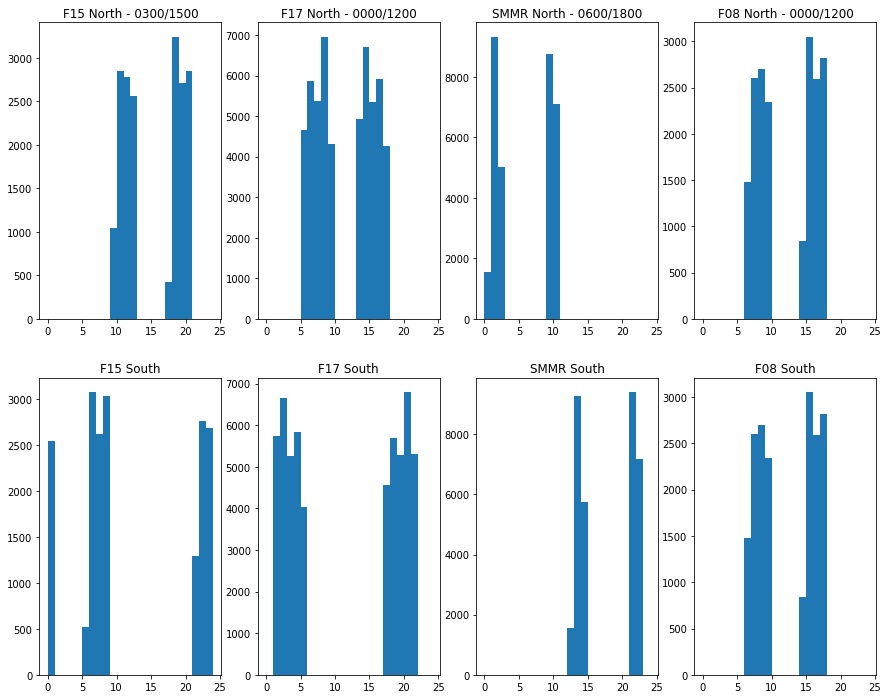

In [18]:
fig = plt.figure(figsize=(15,12))
a = fig.add_subplot(2,4,1)
plt.hist(ftn_F15,bins=(np.arange(25)))
a.set_title('F15 North - 0300/1500')
a = fig.add_subplot(2,4,2)
plt.hist(ftn_F17, bins = (np.arange(25)))
a.set_title('F17 North - 0000/1200')
a = fig.add_subplot(2,4,3)
a.set_title('SMMR North - 0600/1800')
plt.hist(ftn_smmr, bins = (np.arange(25)))
a = fig.add_subplot(2,4,4)
plt.hist(fts_F08, bins = (np.arange(25)))
a.set_title('F08 North - 0000/1200')
a = fig.add_subplot(2,4,5)
plt.hist(fts_F15, bins = (np.arange(25)))
a.set_title('F15 South')
a = fig.add_subplot(2,4,6)
plt.hist(fts_F17, bins = (np.arange(25)))
a.set_title('F17 South')
a = fig.add_subplot(2,4,7)
plt.hist(fts_smmr, bins = (np.arange(25)))
a.set_title('SMMR South')
a = fig.add_subplot(2,4,8)
plt.hist(fts_F08, bins = (np.arange(25)))
a.set_title('F08 South')
plt.show

In [19]:
ftn_F10 = create_ltod(fil_F10[0:30], lat_min = 70.0, lat_max = 71.0)
fts_F10 = create_ltod(fil_F10[0:30], lat_max = -70.0, lat_min = -71.0)
ftn_F11 = create_ltod(fil_F11[50:-1], lat_min = 70.0, lat_max = 71.0)
fts_F11 = create_ltod(fil_F11[50:-1], lat_max = -70.0, lat_min = -71.0)
ftn_F16 = create_ltod(fil_F16[90:-1], lat_min = 70.0, lat_max = 71.0)
fts_F16 = create_ltod(fil_F16[90:-1], lat_max = -70.0, lat_min = -71.0)
ftn_F13 = create_ltod(fil_F13[0:40], lat_min = 70.0, lat_max = 71.0)
fts_F13 = create_ltod(fil_F13[0:40], lat_max = -70.0, lat_min = -71.0)

<function matplotlib.pyplot.show>

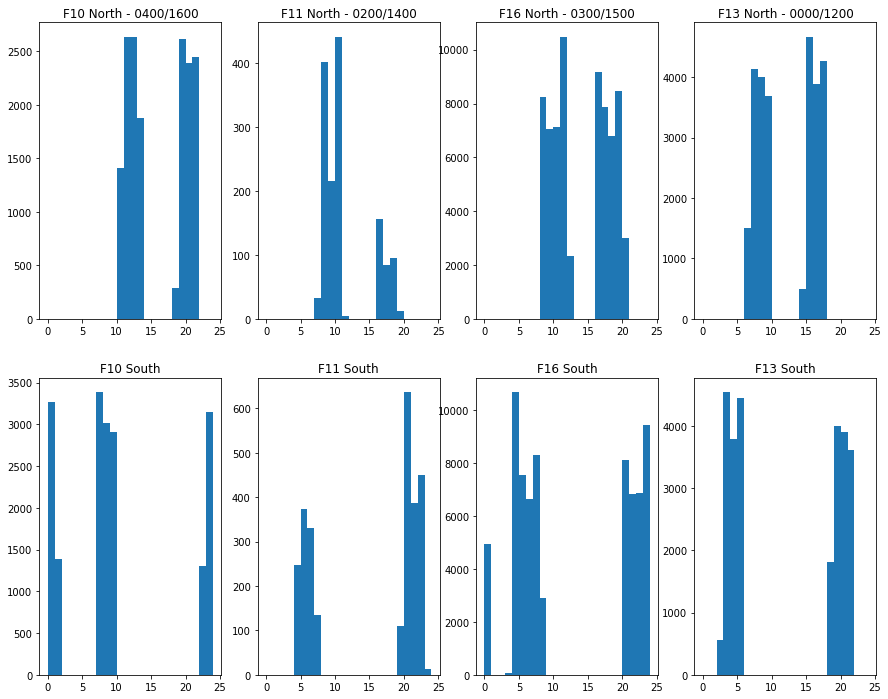

In [21]:
fig = plt.figure(figsize=(15,12))
a = fig.add_subplot(2,4,1)
plt.hist(ftn_F10,bins=(np.arange(25)))
a.set_title('F10 North - 0400/1600')
a = fig.add_subplot(2,4,2)
plt.hist(ftn_F11, bins = (np.arange(25)))
a.set_title('F11 North - 0200/1400')
a = fig.add_subplot(2,4,3)
plt.hist(ftn_F16, bins = (np.arange(25)))
a.set_title('F16 North - 0300/1500')
a = fig.add_subplot(2,4,4)
plt.hist(ftn_F13, bins = (np.arange(25)))
a.set_title('F13 North - 0000/1200')
a = fig.add_subplot(2,4,5)
plt.hist(fts_F10, bins = (np.arange(25)))
a.set_title('F10 South')
a = fig.add_subplot(2,4,6)
plt.hist(fts_F11, bins = (np.arange(25)))
a.set_title('F11 South')
a = fig.add_subplot(2,4,7)
plt.hist(fts_F16, bins = (np.arange(25)))
a.set_title('F16 South')
a = fig.add_subplot(2,4,8)
plt.hist(fts_F13, bins = (np.arange(25)))
a.set_title('F13 South')

plt.show

In [ ]:
hst,bins = np.histogram(ftn_F08,bins=(np.arange(30)-9))
plt.hist(ftn_F08,bins=(np.arange(30)-9))

In [ ]:
hst,bins = np.histogram(fts_F08,bins=(np.arange(30)-9))
plt.hist(fts_F08,bins=(np.arange(30)-9))

In [ ]:
ftn_F15 = create_ltod(fil_F15[70:-1], lat_min = 70.0, lat_max = 71.0)
fts_F15 = create_ltod(fil_F15[70:-1], lat_max = -70.0, lat_min = -71.0)
#
fig = plt.figure()
a = fig.add_subplot(1,2,1)
plt.hist(ftn_F15,bins=(np.arange(30)-9))
a.set_title('F15 North')
a = fig.add_subplot(1,2,2)
plt.hist(fts_F15, bins = (np.arange(30)-9))
a.set_title('F15 South')
plt.show

In [ ]:
ftn_F17 = create_ltod(fil_F17, lat_min = 70.0, lat_max = 71.0)
fts_F17 = create_ltod(fil_F17, lat_max = -70.0, lat_min = -71.0)
#
fig = plt.figure()
a = fig.add_subplot(1,2,1)
plt.hist(ftn_F17,bins=(np.arange(30)-9))
a.set_title('F17 North')
a = fig.add_subplot(1,2,2)
plt.hist(fts_F17, bins = (np.arange(30)-9))
a.set_title('F17 South')
plt.show

In [ ]:
ftn_smmr = create_ltod(fil_smmr, lat_min = 70.0, lat_max = 71.0)
fts_smmr = create_ltod(fil_smmr, lat_max = -70.0, lat_min = -71.0)
#
fig = plt.figure()
a = fig.add_subplot(1,2,1)
plt.hist(ftn_smmr,bins=(np.arange(30)-9))
a.set_title('SMMR North')
a = fig.add_subplot(1,2,2)
plt.hist(fts_smmr, bins = (np.arange(30)-9))
a.set_title('SMMR South')
plt.show

In [ ]:
fil_F10 = sort(glob.glob("F10-1996/*F10_D199601*.nc"))
print (len(fil_F10))

In [ ]:
ftn_F10 = create_ltod(fil_F10[0:30], lat_min = 70.0, lat_max = 71.0)
fts_F10 = create_ltod(fil_F10[0:30], lat_max = -70.0, lat_min = -71.0)
#
fig = plt.figure()
a = fig.add_subplot(1,2,1)
plt.hist(ftn_F10,bins=(np.arange(30)-9))
a.set_title('F10 North')
a = fig.add_subplot(1,2,2)
plt.hist(fts_F10, bins = (np.arange(30)-9))
a.set_title('F10 South')
plt.show

In [ ]:
import numpy.ma as ma

In [ ]:
latm = ma.masked_where((lat < 70.), lat)

In [ ]:
print (np.min(latm), np.max(latm))

In [ ]:
lat_band = ma.masked_where( latm > 71., latm)

In [ ]:
print (np.min(lat_band), np.max(lat_band))


In [ ]:
lon_band = ma.masked_array(lon, lat_band.mask)

In [ ]:
fid.close()


In [ ]:
np.shape(scantime)

In [ ]:
np.shape(lat_band)

In [ ]:
scan_time = array([scantime,]*90).transpose()

In [ ]:
np.shape(scan_time)

In [ ]:
print (scan_time[1,0:5], scan_time[2,0:5])

In [ ]:
scantime_band = ma.masked_array(scan_time, lat_band.mask)

In [ ]:
import time

In [ ]:
print (time.gmtime())

In [ ]:
print (time.gmtime(scantime[0]))

In [ ]:
st = time.strptime("01.01.1987", "%d.%m.%Y")

In [ ]:
print (st)


In [ ]:
import calendar

In [ ]:
seconds_to_epoch = calendar.timegm(st)

In [ ]:
print (time.gmtime(scantime[0]), time.gmtime(scantime[0]+seconds_to_epoch))

In [ ]:
print (time.gmtime(scantime[3219]+seconds_to_epoch))

In [ ]:
str_time_midnight = time.gmtime(scantime[3219]+seconds_to_epoch)
print (str_time_midnight.tm_mon)

In [ ]:
dmid = "%02d.%02d.%d" % (str_time_midnight.tm_mday, str_time_midnight.tm_mon, str_time_midnight.tm_year)
print (dmid)

In [ ]:
utc_midnight = time.strptime(dmid, "%d.%m.%Y")

In [ ]:
print ( utc_midnight)

In [ ]:
utc_seconds = calendar.timegm(utc_midnight)
print (utc_seconds)

So we now have a UTC time and a longitude for each measurement in the latitude band
We need to convert each UTC time to LTOD  
    - the UTC is in seconds since Epoch, so first convert UTC into seconds since midnight 
    - then add the longitude offset in seconds
    - save to a new array
Get the next file and append the result to the new array
Run a historgram

In [ ]:
print (utc_seconds-seconds_to_epoch, scantime[0],  (scantime[0] - (utc_seconds-seconds_to_epoch))/60.)

In [ ]:
offset = utc_seconds-seconds_to_epoch
print (offset)

In [ ]:
new_times = scantime_band - offset

In [ ]:
print (np.min(new_times), np.max(new_times), np.min(scantime_band), np.max(scantime_band))

In [ ]:
print ((np.min(new_times) - np.max(new_times))/60)

In [ ]:
final_times = new_times + (lon_band*4*60.0)
print ( np.min(final_times), np.max(final_times), ((np.min(final_times)-np.max(final_times))/60))

In [ ]:
print (np.min(lon_band), np.max(lon_band))

In [ ]:
all_times = final_times

In [ ]:
np.shape(lat.flatten())
b = np.arange(53)
c=np.concatenate((lat.flatten(),b))

In [ ]:
print (np.shape(c),np.shape(lat.flatten()))
b = np.concatenate((b,lat.flatten()))
print (np.shape(b))

In [ ]:
fid.close()
lat_all = lat.flatten()
lon_all = lon.flatten()
scantime_all = scan_time.flatten()
for files in fil[1:-1]:
    print (files)
    fid = Dataset(files, 'r', 'NETCDF4')
    lat = fid.variables['latitude_loc1'][:]
    lon = fid.variables['longitude_loc1'][:]
    scantime = fid.variables['scan_time_loc1'][:]
    scan_time = array([scantime,]*90).transpose()
    lat_all = np.concatenate((lat_all, lat.flatten()))
    lon_all = np.concatenate((lon_all, lon.flatten()))
    scantime_all = np.concatenate((scantime_all, scan_time.flatten()))
    fid.close()
np.shape(lat_all)
np.shape(lon_all)
np.shape(scantime_all)
    #latm = ma.masked_where((lat < 70.), lat)
    #lat_band = ma.masked_where( latm > 71., latm)
    #lon_band = ma.masked_array(lon, lat_band.mask)
    #scan_time = array([scantime,]*90).transpose()
    #scantime_band = ma.masked_array(scan_time, lat_band.mask)
    #fid.close()

In [ ]:
print (files)

In [ ]:
print (np.shape(lat_all),np.shape(lon_all), np.shape(scantime_all))

In [ ]:
latm = ma.masked_where((lat_all < 70.), lat_all)
lat_band = ma.masked_where( latm > 71., latm)
lon_band = ma.masked_array(lon_all, lat_band.mask)
scantime_band = ma.masked_array(scantime_all, lat_band.mask)

In [ ]:
print (np.min(lat_band), np.max(lat_band), np.min(lon_band), np.max(lon_band), np.min(scantime_band), np.max(scantime_band))

In [ ]:
print (utc_seconds, seconds_to_epoch)

In [ ]:
print (offset)

In [ ]:
final_times = (scantime_band-offset) + (lon_band*4*60.0)

In [ ]:
plt.hist(final_times)

In [ ]:
print( np.min(final_times/3600.), np.max(final_times/3600.))

In [ ]:
ftimes = final_times/3600.
ftimes[ftimes > 24.0] = ftimes[ftimes > 24.0]-24.0

In [ ]:
print (np.min(ftimes), np.max(ftimes))

In [ ]:
plt.hist(ftimes,bins=30)

In [ ]:
plt.hist(final_times, bins=30)

In [ ]:
hst,bins = np.histogram(ftimes,bins=(np.arange(30)-9))
plt.hist(ftimes,bins=(np.arange(48)-24))

In [ ]:
print (hst, bins)

In [ ]:
print (np.max(ftimes))

In [ ]:
def create_ltod(files, lat_min=70., lat_max=71.):
    """ This function takes a list of gsx swath files as an argument and
        calculates the local time of each measurement in a specified latitude band
        It returns a 1-D array of the local times (in hours wrt midnight), 
        suitable for creating a histogram """
    
    fid = Dataset(files[0], 'r', 'NETCDF4')
    lat = fid.variables['latitude_loc1'][:]
    lon = fid.variables['longitude_loc1'][:]
    scantime = fid.variables['scan_time_loc1'][:]
    meas = len(fid.dimensions['measurements_loc1'])
    scan_time = array([scantime,]*meas).transpose()
    lat_all = lat.flatten()
    lon_all = lon.flatten()
    offset_seconds = seconds_to_midnight(scantime[0]) # get the offset to midnight for the first scanline
    scantime_all = scan_time.flatten() - offset_seconds
    fid.close()
    for fil in files[1:-1]:
        #print (fil)
        fid = Dataset(fil, 'r', 'NETCDF4')
        lat = fid.variables['latitude_loc1'][:]
        lon = fid.variables['longitude_loc1'][:]
        scantime = fid.variables['scan_time_loc1'][:]
        meas = len(fid.dimensions['measurements_loc1'])
        scan_time = array([scantime,]*meas).transpose()
        lat_all = np.concatenate((lat_all, lat.flatten()))
        lon_all = np.concatenate((lon_all, lon.flatten()))
        offset_seconds = seconds_to_midnight(scantime[0])
        scantime_all = np.concatenate((scantime_all, (scan_time.flatten() - offset_seconds)))
        fid.close()
    latm = ma.masked_where((lat_all < lat_min), lat_all)
    lat_band = ma.masked_where( latm > lat_max, latm)
    lon_band = ma.masked_array(lon_all, lat_band.mask)
    scantime_band = ma.masked_array(scantime_all, lat_band.mask)
    final_times = scantime_band + (lon_band*4*60.0)
    ftimes = final_times/3600.
    ftimes[ftimes > 24.0] = ftimes[ftimes > 24.0]-24.0
    return ftimes
                                      


In [ ]:
def seconds_to_midnight(seconds):
    """ This function calculates the number of seconds to midnight of the input
        time.  This is used to convert the scan times in the file to local time
        for that day """
    st = time.strptime("01.01.1987", "%d.%m.%Y")
    seconds_to_epoch = calendar.timegm(st)
    # get file epoch date in seconds since 1970
    str_date = time.gmtime(seconds + seconds_to_epoch)
    # get file date from number of seconds since 1987
    dmid = "%02d.%02d.%d" % (str_date.tm_mday, str_date.tm_mon, str_date.tm_year)
    utc_midnight = time.strptime(dmid, "%d.%m.%Y")
    utc_seconds_to_midnight = calendar.timegm(utc_midnight)
    # get midnight of file date in seconds
    return (utc_seconds_to_midnight - seconds_to_epoch)
    

In [ ]:
print (seconds_to_midnight(6.06530381e+08 ))

In [ ]:
ft = create_ltod(fil)

In [ ]:
np.shape(ft)

In [ ]:
ftimes = ft/3600.
ftimes[ftimes > 24.0] = ftimes[ftimes > 24.0]-24.0

In [ ]:
print (np.min(ftimes), np.max(ftimes))

In [ ]:
hst,bins = np.histogram(ftimes,bins=(np.arange(30)-9))
plt.hist(ftimes,bins=(np.arange(30)-9))

In [ ]:
%cd /projects/PMESDR/vagrant/pmadden/csu_ssmis_2006

In [ ]:
filF16 = np.concatenate((sort(glob.glob("gsx_*20061226*.nc")),sort(glob.glob("gsx_*20061227*.nc"))))

In [ ]:
print (fillist)

In [ ]:
filesF16 = np.concatenate((filF16, sort(glob.glob("gsx_*20061218*.nc"))))

In [ ]:
print (len(filesF16))

In [ ]:
ft_F16s = create_ltod(filesF16, lat_min=-71.0, lat_max=-70.0)

In [ ]:
?ft

In [ ]:
ftimes = ft/3600.
ftimes[ftimes > 24.0] = ftimes[ftimes > 24.0]-24.0

In [ ]:
print (np.min(ftimes), np.max(ftimes))

In [ ]:
hst,bins = np.histogram(ft_F16,bins=(np.arange(30)-9))
plt.hist(ft_F16,bins=(np.arange(30)-9))

In [ ]:
hst,bins = np.histogram(ft_F16s,bins=(np.arange(30)-9))
plt.hist(ft_F16s,bins=(np.arange(30)-9))

In [ ]:
ftimes = fts/3600.
ftimes[ftimes > 24.0] = ftimes[ftimes > 24.0]-24.0
print (np.min(ftimes), np.max(ftimes))

In [ ]:
ft = create_ltod(files, lat_min=70., lat_max=71.)

In [ ]:
ftimes = ft/3600.
ftimes[ftimes > 24.0] = ftimes[ftimes > 24.0]-24.0
print (np.min(ftimes), np.max(ftimes))

In [ ]:
ftsouth = create_ltod(files, lat_min=-71., lat_max=-70.)

In [ ]:
stimes = ftsouth/3600.
stimes[stimes > 24.0] = stimes[stimes > 24.0] - 24.0
print (np.min(stimes), np.max(stimes))

In [ ]:
hst,bins = np.histogram(ftimes,bins=(np.arange(48)-24))
plt.hist(ftimes,bins=(np.arange(48)-24))

In [ ]:
hst,bins = np.histogram(stimes,bins=(np.arange(30)-9))
plt.hist(stimes,bins=(np.arange(30)-9))

In [ ]:
import numpy as np
a = np.arange(10)
print (a)

In [ ]:
print (np.shape(np.repeat(a,2)), np.repeat(a, 2))

In [ ]:
b = np.repeat(a,5)
c = np.reshape(b, (10,5))

In [ ]:
print (np.shape(b), np.shape(c), c)

In [ ]:
d = np.reshape(b,((len(b)/5), 5))
print(d)